# Model Demo: MassFormer

## 1. Imports Libraries

In [13]:
%pip install transformers
%pip install dgl
%pip install dgllife

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import dgl
import dgllife.utils as chemutils
import torch as th
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.utils.data as th_data
import massformer.algos1
import massformer.algos2
from rdkit import Chem
from tqdm import tqdm
from torch_geometric.data import Data
from transformers.models.graphormer.collating_graphormer import GraphormerDataCollator, preprocess_item
import src.massformer.utils as utils

## 2. Data Handling

In [15]:
# spec_df = pd.read_pickle("data/proc_demo/spec_df.pkl")
# mol_df = pd.read_pickle("data/proc_demo/mol_df.pkl")
# toy_spec_df = spec_df.sample(n=1000, replace=False, random_state=420)
# toy_mol_df = mol_df[mol_df["mol_id"].isin(toy_spec_df["mol_id"])]
# toy_spec_df.to_pickle("data/proc_demo/toy_spec_df.pkl")
# toy_mol_df.to_pickle("data/proc_demo/toy_mol_df.pkl")
# toy_mol_df = toy_mol_df.set_index(
#             "mol_id", drop=False).sort_index().rename_axis(None)
# print(toy_spec_df)
# print(toy_mol_df)

In [16]:
# print(toy_spec_df)
# print(toy_mol_df)

### Data Collator

In [17]:
from typing import List
class MassFormerDataCollator(GraphormerDataCollator):

    def __init__(self, spatial_pos_max=1024):

        super().__init__(spatial_pos_max=spatial_pos_max, on_the_fly_processing=False)
        # custom init stuff for MassFormer

    def __call__(self, items: List[dict]):

        print(f"all keys = {list(items[0].keys())}")

        # this list of arguments is basically what preprocess_item produces
        gf_keys = ['input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels']
        # gf_related_keys = ['spatial_pos', 'labels', 'y', 'edge_index', 'edge_attr', 'num_nodes', 'attn_bias', 'input_nodes', 'attn_edge_type', 'in_degree', 'input_edges', 'out_degree', 'x']
        gf_related_keys = ['y', 'edge_index', 'edge_attr', 'num_nodes', 'x']
    
        gf_items = []
        for item in items:
            gf_item = {}
            for k in gf_keys:
                # note: some keys are optional, so we need to check for them
                if k in item:
                    gf_item[k] = item.pop(k)
                else:
                    # helpful debugging message
                    print(f"Warning: {k} not found in item")
            gf_items.append(gf_item)


        # custom call stuff for MassFormer
        gf_collated = super().__call__(gf_items)
        print(f"gf_collated_keys = {list(gf_collated.keys())}")

        # After collating gf aspects, remove gf-related keys for mass spec collation
        for item in items:
            for k in gf_related_keys:
                # note: some keys are optional, so we need to check for them
                if k in item:
                    item.pop(k)
                else:
                    print(f"Warning: {k} not found in item")

        # now, let's handle the rest of the stuff
        other_collated = {k: [] for k in items[0].keys()}
        for data_d in items:
            for k, v in data_d.items():
                    other_collated[k].append(v)
        for k, v in other_collated.items():
            if isinstance(items[0][k], th.Tensor):
                other_collated[k] = th.cat(v, dim=0)
            elif isinstance(items[0][k], list):
                other_collated[k] = utils.flatten_lol(v)
            else:
                raise ValueError(f"{type(items[0][k])} is not supported")

        print(f"other_collated_keys = {list(other_collated.keys())}")

        # now, let's combine the two collated dicts
        both_collated = {**gf_collated, **other_collated}

        return both_collated

### Base Dataset

In [18]:
class TrainSubset(th_data.Subset):

    def __getitem__(self, idx):
        return self.dataset.__getitem__(self.indices[idx])
    
class BaseDataset(th_data.Dataset):

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
        assert os.path.isdir(self.proc_dp), self.proc_dp
        self.spec_df = pd.read_pickle(
            os.path.join(self.proc_dp, "spec_df.pkl"))
        self.mol_df = pd.read_pickle(
            os.path.join(self.proc_dp, "mol_df.pkl"))
        self.mol_df = self.mol_df[self.mol_df["mol_id"].isin(self.spec_df["mol_id"])]

        # generate toy spec and mol df for faster processing
        self.toy_spec_df = self.spec_df.sample(n=2000, replace=False, random_state=420)
        self.toy_mol_df = self.mol_df[self.mol_df["mol_id"].isin(self.toy_spec_df["mol_id"])]

        # save toy spec and mol df as pickle
        self.toy_spec_df.to_pickle("data/proc_demo/toy_spec_df.pkl")
        self.toy_mol_df.to_pickle("data/proc_demo/toy_mol_df.pkl")

        # use toy df
        self.spec_df = self.toy_spec_df
        self.mol_df = self.toy_mol_df


        self._select_spec()
        self._setup_spec_metadata_dicts()
        # use mol_id as index for speedy access
        self.mol_df = self.mol_df.set_index(
            "mol_id", drop=False).sort_index().rename_axis(None)


    def _select_spec(self):

        masks = []
        # dataset mask
        dset_mask = self.spec_df["dset"].isin(
            self.primary_dset + self.secondary_dset)
        masks.append(dset_mask)
        # instrument type
        inst_type_mask = self.spec_df["inst_type"].isin(self.inst_type)
        masks.append(inst_type_mask)
        # frag mode
        frag_mode_mask = self.spec_df["frag_mode"].isin(self.frag_mode)
        masks.append(frag_mode_mask)
        # ion mode
        ion_mode_mask = self.spec_df["ion_mode"] == self.ion_mode
        masks.append(ion_mode_mask)
        # precursor type
        if self.ion_mode == "P":
            prec_type_mask = self.spec_df["prec_type"].isin(self.pos_prec_type)
        elif self.ion_mode == "N":
            prec_type_mask = self.spec_df["prec_type"].isin(self.neg_prec_type)
        else:
            assert self.ion_mode == "EI"
            prec_type_mask = self.spec_df["prec_type"] == "EI"
        masks.append(prec_type_mask)
        # resolution
        if self.res != []:
            res_mask = self.spec_df["res"].isin(self.res)
            masks.append(res_mask)
        # collision energy
        ce_mask = ~(self.spec_df["ace"].isna() & self.spec_df["nce"].isna())
        masks.append(ce_mask)
        # spectrum type
        if self.ion_mode == "EI":
            spec_type_mask = self.spec_df["spec_type"] == "EI"
        else:
            spec_type_mask = self.spec_df["spec_type"] == "MS2"
        masks.append(spec_type_mask)
        # maximum mz allowed
        mz_mask = self.spec_df["peaks"].apply(
            lambda peaks: max(peak[0] for peak in peaks) < self.mz_max)
        masks.append(mz_mask)
        # precursor mz
        prec_mz_mask = ~self.spec_df["prec_mz"].isna()
        masks.append(prec_mz_mask)
        # single molecule
        multi_mol_ids = self.mol_df[self.mol_df["smiles"].str.contains(
            "\\.")]["mol_id"]
        single_mol_mask = ~self.spec_df["mol_id"].isin(multi_mol_ids)
        masks.append(single_mol_mask)
        # neutral molecule
        charges = self.mol_df["mol"].apply(utils.mol_to_charge)
        charged_ids = self.mol_df[charges != 0]["mol_id"]
        neutral_mask = ~self.spec_df["mol_id"].isin(charged_ids)
        # print(neutral_mask.sum())
        masks.append(neutral_mask)
        # put them together
        all_mask = masks[0]
        for mask in masks:
            all_mask = all_mask & mask
        if np.sum(all_mask) == 0:
            raise ValueError("select removed all items")
        self.spec_df = self.spec_df[all_mask].reset_index(drop=True)
        self._setup_ce()
        # get group_id
        n_before_group = self.spec_df.shape[0]
        group_df = self.spec_df.drop(
            columns=[
                "spec_id",
                "peaks",
                "nce",
                "ace",
                "res",
                "prec_mz",
                "ri",
                "col_gas"])
        assert not group_df.isna().any().any()
        group_df = group_df.drop_duplicates()
        group_df.loc[:, "group_id"] = np.arange(group_df.shape[0])
        self.spec_df = self.spec_df.merge(group_df, how="inner")
        del group_df
        n_after_group = self.spec_df.shape[0]
        assert n_before_group == n_after_group
        # compute stats
        for dset in self.primary_dset + self.secondary_dset:
            dset_spec_df = self.spec_df[self.spec_df["dset"] == dset]
            num_specs = dset_spec_df["spec_id"].nunique()
            num_mols = dset_spec_df["mol_id"].nunique()
            num_groups = dset_spec_df["group_id"].nunique()
            num_ces_per_group = dset_spec_df[["group_id", self.ce_key]].groupby(
                by="group_id").count()[self.ce_key].mean()
            print(f">>> {dset}")
            print(
                f"> num_spec = {num_specs}, num_mol = {num_mols}, num_group = {num_groups}, num_ce_per_group = {num_ces_per_group}")
        # subsample
        if self.subsample_size > 0:
            self.spec_df = self.spec_df.groupby("mol_id").sample(
                n=self.subsample_size, random_state=self.subsample_seed, replace=True)
            self.spec_df = self.spec_df.reset_index(drop=True)
        else:
            self.spec_df = self.spec_df
        # num_entries
        if self.num_entries > 0:
            self.spec_df = self.spec_df.sample(
                n=self.num_entries,
                random_state=self.subsample_seed,
                replace=False)
            self.spec_df = self.spec_df.reset_index(drop=True)
        # only keep mols with spectra
        self.mol_df = self.mol_df[self.mol_df["mol_id"].isin(
            self.spec_df["mol_id"])]
        self.mol_df = self.mol_df.reset_index(drop=True)

    def _setup_ce(self):

        if self.convert_ce:
            if self.ce_key == "ace":
                other_ce_key = "nce"
                ce_conversion_fn = utils.nce_to_ace
            else:
                other_ce_key = "ace"
                ce_conversion_fn = utils.ace_to_nce
            convert_mask = self.spec_df[self.ce_key].isna()
            assert not self.spec_df.loc[convert_mask,
                                        other_ce_key].isna().any()
            self.spec_df.loc[convert_mask, self.ce_key] = self.spec_df[convert_mask].apply(
                ce_conversion_fn, axis=1)
            assert not self.spec_df[self.ce_key].isna().any()
        else:
            self.spec_df = self.spec_df.dropna(
                axis=0, subset=[
                    self.ce_key]).reset_index(
                drop=True)

    def _setup_spec_metadata_dicts(self):

        # featurize spectral metadata
        # we can assume that the dataset is filtered (using the method above)
        # to only include these values
        inst_type_list = self.inst_type
        if self.ion_mode == "P":
            prec_type_list = self.pos_prec_type
        elif self.ion_mode == "N":
            prec_type_list = self.neg_prec_type
        else:
            assert self.ion_mode == "EI"
            prec_type_list = ["EI"]
        frag_mode_list = self.frag_mode
        self.inst_type_c2i = {
            string: i for i,
            string in enumerate(inst_type_list)}
        self.inst_type_i2c = {
            i: string for i,
            string in enumerate(inst_type_list)}
        self.prec_type_c2i = {
            string: i for i,
            string in enumerate(prec_type_list)}
        self.prec_type_i2c = {
            i: string for i,
            string in enumerate(prec_type_list)}
        self.frag_mode_c2i = {
            string: i for i,
            string in enumerate(frag_mode_list)}
        self.frag_mode_i2c = {
            i: string for i,
            string in enumerate(frag_mode_list)}
        self.num_inst_type = len(inst_type_list)
        self.num_prec_type = len(prec_type_list)
        self.num_frag_mode = len(frag_mode_list)
        self.max_ce = self.spec_df[self.ce_key].max()
        self.mean_ce = self.spec_df[self.ce_key].mean()
        self.std_ce = self.spec_df[self.ce_key].std()

    def __getitem__(self, idx):

        spec_entry = self.spec_df.iloc[idx]
        mol_id = spec_entry["mol_id"]
        # mol_entry = self.mol_df[self.mol_df["mol_id"] == mol_id].iloc[0]
        mol_entry = self.mol_df.loc[mol_id]
        data = self.process_entry(spec_entry, mol_entry["mol"])
        return data


    def __len__(self):

        return self.spec_df.shape[0]

    def bin_func(self, mzs, ints, return_index=False):

        assert self.ints_thresh == 0., self.ints_thresh
        return utils.bin_func(
            mzs,
            ints,
            self.mz_max,
            self.mz_bin_res,
            self.ints_thresh,
            return_index)

    def transform_func(self, spec):

        if self.process_spec_old:
            spec = utils.process_spec_old(
                spec,
                self.transform,
                self.spectrum_normalization,
                self.ints_thresh)
        else:
            spec = utils.process_spec(
                th.as_tensor(spec),
                self.transform,
                self.spectrum_normalization)
            spec = spec.numpy()
        return spec

    def get_split_masks(
            self,
            val_frac,
            test_frac,
            sec_frac,
            split_key,
            split_seed):

        assert split_key in ["inchikey_s", "scaffold"], split_key
        assert len(self.secondary_dset) <= 1, self.secondary_dset
        # primary
        prim_mask = self.spec_df["dset"].isin(self.primary_dset)
        prim_mol_id = self.spec_df[prim_mask]["mol_id"].unique()
        prim_key = set(
            self.mol_df[self.mol_df["mol_id"].isin(prim_mol_id)][split_key])
        # secondary
        sec_mask = self.spec_df["dset"].isin(self.secondary_dset)
        sec_mol_id = self.spec_df[sec_mask]["mol_id"].unique()
        sec_key = set(
            self.mol_df[self.mol_df["mol_id"].isin(sec_mol_id)][split_key])
        sec_key_list = sorted(list(sec_key))
        # print(sec_key_list[:5])
        # sample secondary keys
        with utils.np_temp_seed(split_seed):
            sec_num = round(len(sec_key_list) * sec_frac)
            sec_key_list = np.random.choice(
                sec_key_list, size=sec_num, replace=False).tolist()
            sec_key = set(sec_key_list)
            # print(sec_key_list[:5])
            sec_mol_id = self.mol_df[self.mol_df[split_key].isin(
                sec_key_list) & self.mol_df["mol_id"].isin(sec_mol_id)]["mol_id"].unique()
            sec_mask = self.spec_df["mol_id"].isin(sec_mol_id) & sec_mask
            # print(split_seed,sec_num,sec_mask.sum())
        # get keys (secondary might same compounds as primary does!)
        prim_only_key = prim_key - sec_key
        sec_only_key = sec_key
        prim_only_key_list = sorted(list(prim_only_key))
        both_key = prim_key & sec_key
        # compute number for each split
        test_num = round(len(prim_only_key_list) * test_frac)
        val_num = round(len(prim_only_key_list) * val_frac)
        # make sure that test set gets all of the casmi keys!
        prim_only_and_casmi = set()
        if test_num > 0:
            assert len(prim_only_and_casmi) <= test_num
            test_num -= len(prim_only_and_casmi)
        prim_only_no_casmi_key_list = [
            k for k in prim_only_key_list if not (
                k in prim_only_and_casmi)]
        assert len(set(prim_only_no_casmi_key_list) & prim_only_and_casmi) == 0
        # do the split
        with utils.np_temp_seed(split_seed):
            prim_only_test_num = max(test_num - len(both_key), 0)
            test_key = set(
                np.random.choice(
                    prim_only_no_casmi_key_list,
                    size=prim_only_test_num,
                    replace=False))
            test_key = test_key.union(prim_only_and_casmi).union(both_key)
            train_val_key = prim_only_key - test_key
            val_key = set(
                np.random.choice(
                    sorted(
                        list(train_val_key)),
                    size=val_num,
                    replace=False))
            train_key = train_val_key - val_key
            assert len(train_key & sec_only_key) == 0
            assert len(val_key & sec_only_key) == 0
            # assert len(test_key & sec_only_key) == 0
            assert len(train_key & prim_only_and_casmi) == 0
            assert len(val_key & prim_only_and_casmi) == 0
        # get ids and create masks
        train_mol_id = self.mol_df["mol_id"][self.mol_df[split_key].isin(
            list(train_key))].unique()
        val_mol_id = self.mol_df["mol_id"][self.mol_df[split_key].isin(
            list(val_key))].unique()
        test_mol_id = self.mol_df["mol_id"][self.mol_df[split_key].isin(
            list(test_key))].unique()
        train_mask = self.spec_df["mol_id"].isin(train_mol_id)
        val_mask = self.spec_df["mol_id"].isin(val_mol_id)
        test_mask = self.spec_df["mol_id"].isin(test_mol_id)
        prim_mask = train_mask | val_mask | test_mask
        prim_mol_id = pd.Series(
            list(set(train_mol_id) | set(val_mol_id) | set(test_mol_id)))
        # note: primary can include secondary molecules in the test split
        sec_masks = [(self.spec_df["dset"] == dset) & (
            self.spec_df["mol_id"].isin(sec_mol_id)) for dset in self.secondary_dset]
        assert (train_mask & val_mask & test_mask).sum() == 0
        print("> primary")
        print("splits: train, val, test, total")
        print(
            f"spec: {train_mask.sum()}, {val_mask.sum()}, {test_mask.sum()}, {prim_mask.sum()}")
        print(
            f"mol: {len(train_mol_id)}, {len(val_mol_id)}, {len(test_mol_id)}, {len(prim_mol_id)}")
        if len(self.secondary_dset) > 0:
            print("> secondary")
        for sec_idx, sec_dset in enumerate(self.secondary_dset):
            cur_sec = self.spec_df[sec_masks[sec_idx]]
            cur_sec_mol_id = cur_sec["mol_id"]
            cur_both_mol_mask = self.spec_df["mol_id"].isin(
                set(prim_mol_id) & set(cur_sec_mol_id))
            cur_prim_both = self.spec_df[prim_mask & cur_both_mol_mask]
            cur_sec_both = self.spec_df[sec_masks[sec_idx] & cur_both_mol_mask]
            print(
                f"{sec_dset} spec = {cur_sec.shape[0]}, mol = {cur_sec_mol_id.nunique()}")
            print(
                f"{sec_dset} overlap: prim spec = {cur_prim_both.shape[0]}, sec spec = {cur_sec_both.shape[0]}, mol = {cur_prim_both['mol_id'].nunique()}")
        return train_mask, val_mask, test_mask, sec_masks

    def get_spec_feats(self, spec_entry):

        # convert to a dense vector
        mol_id = th.tensor(spec_entry["mol_id"]).unsqueeze(0)
        spec_id = th.tensor(spec_entry["spec_id"]).unsqueeze(0)
        group_id = th.tensor(spec_entry["group_id"]).unsqueeze(0)
        mzs = [peak[0] for peak in spec_entry["peaks"]]
        ints = [peak[1] for peak in spec_entry["peaks"]]
        prec_mz = spec_entry["prec_mz"]
        prec_mz_bin = self.bin_func([prec_mz], None, return_index=True)[0]
        prec_diff = max(mz - prec_mz for mz in mzs)
        num_peaks = len(mzs)
        bin_spec = self.transform_func(self.bin_func(mzs, ints))
        spec = th.as_tensor(bin_spec, dtype=th.float32).unsqueeze(0)
        col_energy = spec_entry[self.ce_key]
        inst_type = spec_entry["inst_type"]
        prec_type = spec_entry["prec_type"]
        frag_mode = spec_entry["frag_mode"]
        charge = utils.get_charge(prec_type)
        inst_type_idx = self.inst_type_c2i[inst_type]
        prec_type_idx = self.prec_type_c2i[prec_type]
        frag_mode_idx = self.frag_mode_c2i[frag_mode]
        # same as prec_mz_bin but tensor
        prec_mz_idx = th.tensor(
            min(prec_mz_bin, spec.shape[1] - 1)).unsqueeze(0)
        assert prec_mz_idx < spec.shape[1], (prec_mz_bin,
                                             prec_mz_idx, spec.shape)
        if self.preproc_ce == "normalize":
            col_energy_meta = th.tensor(
                [(col_energy - self.mean_ce) / (self.std_ce + utils.EPS)], dtype=th.float32)
        elif self.preproc_ce == "quantize":
            ce_bins = np.arange(0, 161, step=20)  # 8 bins
            ce_idx = np.digitize(col_energy, bins=ce_bins, right=False)
            col_energy_meta = th.ones([len(ce_bins) + 1], dtype=th.float32)
            col_energy_meta[ce_idx] = 1.
        else:
            assert self.preproc_ce == "none", self.preproc_ce
            col_energy_meta = th.tensor([col_energy], dtype=th.float32)
        inst_type_meta = th.as_tensor(
            utils.np_one_hot(
                inst_type_idx,
                num_classes=self.num_inst_type),
            dtype=th.float32)
        prec_type_meta = th.as_tensor(
            utils.np_one_hot(
                prec_type_idx,
                num_classes=self.num_prec_type),
            dtype=th.float32)
        frag_mode_meta = th.as_tensor(
            utils.np_one_hot(
                frag_mode_idx,
                num_classes=self.num_frag_mode),
            dtype=th.float32)
        spec_meta_list = [
            col_energy_meta,
            inst_type_meta,
            prec_type_meta,
            frag_mode_meta,
            col_energy_meta]
        spec_meta = th.cat(spec_meta_list, dim=0).unsqueeze(0)
        spec_feats = {
            "spec": spec,
            "prec_mz": [prec_mz],
            "prec_mz_bin": [prec_mz_bin],
            "prec_diff": [prec_diff],
            "num_peaks": [num_peaks],
            "inst_type": [inst_type],
            "prec_type": [prec_type],
            "frag_mode": [frag_mode],
            "col_energy": [col_energy],
            "charge": [charge],
            "spec_meta": spec_meta,
            "mol_id": mol_id,
            "spec_id": spec_id,
            "group_id": group_id,
            "prec_mz_idx": prec_mz_idx
        }
        if "lda_topic" in spec_entry:
            spec_feats["lda_topic"] = th.tensor(
                spec_entry["lda_topic"]).unsqueeze(0)
        return spec_feats

    def get_dataloaders(self, run_d):

        val_frac = run_d["val_frac"]
        test_frac = run_d["test_frac"]
        sec_frac = run_d["sec_frac"]
        split_key = run_d["split_key"]
        split_seed = run_d["split_seed"]
        assert run_d["batch_size"] % run_d["grad_acc_interval"] == 0
        batch_size = run_d["batch_size"] // run_d["grad_acc_interval"]
        num_workers = run_d["num_workers"]
        pin_memory = run_d["pin_memory"] if run_d["device"] != "cpu" else False

        train_mask, val_mask, test_mask, sec_masks = self.get_split_masks(
            val_frac, test_frac, sec_frac, split_key, split_seed)
        all_idx = np.arange(len(self))
        # th_data.RandomSampler()
        train_ss = TrainSubset(self, all_idx[train_mask])
        # th_data.RandomSampler(th_data.Subset(self,all_idx[val_mask]))
        val_ss = th_data.Subset(self, all_idx[val_mask])
        # th_data.RandomSampler(th_data.Subset(self,all_idx[test_mask]))
        test_ss = th_data.Subset(self, all_idx[test_mask])
        sec_ss = [th_data.Subset(self, all_idx[sec_mask])
                  for sec_mask in sec_masks]

        collate_fn = self.get_collate_fn()
        if len(train_ss) > 0:
            train_dl = th_data.DataLoader(
                train_ss,
                batch_size=batch_size,
                collate_fn=collate_fn,
                num_workers=num_workers,
                pin_memory=pin_memory,
                shuffle=True,
                drop_last=True  # this is to prevent single data batches that mess with batchnorm
            )
            train_dl_2 = th_data.DataLoader(
                train_ss,
                batch_size=batch_size,
                collate_fn=collate_fn,
                num_workers=num_workers,
                pin_memory=pin_memory,
                shuffle=False,
                drop_last=False
            )
        else:
            train_dl = train_dl_2 = None
        if len(val_ss) > 0:
            val_dl = th_data.DataLoader(
                val_ss,
                batch_size=batch_size,
                collate_fn=collate_fn,
                num_workers=num_workers,
                pin_memory=pin_memory,
                shuffle=False,
                drop_last=False
            )
        else:
            val_dl = None
        if len(test_ss) > 0:
            test_dl = th_data.DataLoader(
                test_ss,
                batch_size=batch_size,
                collate_fn=collate_fn,
                num_workers=num_workers,
                pin_memory=pin_memory,
                shuffle=False,
                drop_last=False
            )
        else:
            test_dl = None
        sec_dls = []
        for ss in sec_ss:
            dl = th_data.DataLoader(
                ss,
                batch_size=batch_size,
                collate_fn=collate_fn,
                num_workers=num_workers,
                pin_memory=pin_memory,
                shuffle=False,
                drop_last=False
            )
            sec_dls.append(dl)

        # set up dl_dict
        dl_dict = {}
        dl_dict["train"] = train_dl
        dl_dict["primary"] = {
            "train": train_dl_2,
            "val": val_dl,
            "test": test_dl
        }
        dl_dict["secondary"] = {}
        for sec_idx, sec_dset in enumerate(self.secondary_dset):
            dl_dict["secondary"][f"{sec_dset}"] = sec_dls[sec_idx]

        # set up split_id_dict
        split_id_dict = {}
        split_id_dict["primary"] = {}
        split_id_dict["primary"]["train"] = self.spec_df.iloc[all_idx[train_mask]
                                                              ]["spec_id"].to_numpy()
        split_id_dict["primary"]["val"] = self.spec_df.iloc[all_idx[val_mask]
                                                            ]["spec_id"].to_numpy()
        split_id_dict["primary"]["test"] = self.spec_df.iloc[all_idx[test_mask]
                                                             ]["spec_id"].to_numpy()
        split_id_dict["secondary"] = {}
        for sec_idx, sec_dset in enumerate(self.secondary_dset):
            split_id_dict["secondary"][sec_dset] = self.spec_df.iloc[all_idx[sec_masks[sec_idx]]
                                                                     ]["spec_id"].to_numpy()

        return dl_dict, split_id_dict

    def get_track_dl(
            self,
            idx,
            num_rand_idx=0,
            topk_idx=None,
            bottomk_idx=None,
            other_idx=None,
            spec_ids=None):

        track_seed = 5585
        track_dl_dict = {}
        collate_fn = self.get_collate_fn()
        if num_rand_idx > 0:
            with utils.np_temp_seed(track_seed):
                rand_idx = np.random.choice(
                    idx, size=num_rand_idx, replace=False)
            rand_dl = th_data.DataLoader(
                th_data.Subset(self, rand_idx),
                batch_size=1,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=False,
                shuffle=False,
                drop_last=False
            )
            track_dl_dict["rand"] = rand_dl
        if not (topk_idx is None):
            topk_idx = idx[topk_idx]
            topk_dl = th_data.DataLoader(
                th_data.Subset(self, topk_idx),
                batch_size=1,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=False,
                shuffle=False,
                drop_last=False
            )
            track_dl_dict["topk"] = topk_dl
        if not (bottomk_idx is None):
            bottomk_idx = idx[bottomk_idx]
            bottomk_dl = th_data.DataLoader(
                th_data.Subset(self, bottomk_idx),
                batch_size=1,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=False,
                shuffle=False,
                drop_last=False
            )
            track_dl_dict["bottomk"] = bottomk_dl
        if not (other_idx is None):
            other_idx = idx[other_idx]
            other_dl = th_data.DataLoader(
                th_data.Subset(self, other_idx),
                batch_size=1,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=False,
                shuffle=False,
                drop_last=False
            )
            track_dl_dict["other"] = other_dl
        if not (spec_ids is None):
            # preserves order
            spec_idx = []
            for spec_id in spec_ids:
                spec_idx.append(
                    int(self.spec_df[self.spec_df["spec_id"] == spec_id].index[0]))
            spec_idx = np.array(spec_idx)
            spec_dl = th_data.DataLoader(
                th_data.Subset(self, spec_idx),
                batch_size=1,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=False,
                shuffle=False,
                drop_last=False
            )
            track_dl_dict["spec"] = spec_dl
        return track_dl_dict

 
    def get_data_dims(self):

        data = self.__getitem__(0)
        dim_d = {}
        if self.is_fp_dset:
            fp_dim = data["fp"].shape[1]
        else:
            fp_dim = -1
        if self.is_graph_dset:
            # node
            if self.atom_feature_mode == "pretrain":
                n_dim = -1
            else:
                n_dim = data["graph"].ndata['h'].shape[1]
            # edge
            if self.bond_feature_mode == "none":
                e_dim = 0
            elif self.bond_feature_mode == "pretrain":
                e_dim = -1
            else:
                e_dim = data["graph"].edata['h'].shape[1]
        else:
            n_dim = e_dim = -1
        c_dim = l_dim = -1
        if self.spec_meta_global:
            g_dim = data["spec_meta"].shape[1]
        else:
            g_dim = 0  # -1
        o_dim = data["spec"].shape[1]
        dim_d = {
            "fp_dim": fp_dim,
            "n_dim": n_dim,
            "e_dim": e_dim,
            "c_dim": c_dim,
            "l_dim": l_dim,
            "g_dim": g_dim,
            "o_dim": o_dim
        }
        return dim_d

    def get_collate_fn(self):
        return MassFormerDataCollator()

    def process_entry(self, spec_entry, mol):

        # initialize data with shared attributes
        spec_feats = self.get_spec_feats(spec_entry)
        data_d = {**spec_feats}
        data_d["smiles"] = [utils.mol_to_smiles(mol)]
        data_d["formula"] = [utils.mol_to_formula(mol)]
        graph = utils.mol2graph(mol)
        data = utils.graph2data(graph)
        items = preprocess_item(data)
        data_d.update(items)
        return data_d

    def load_all(self, keys):

        collate_fn = self.get_collate_fn()
        dl = th_data.DataLoader(
            self,
            batch_size=100,
            collate_fn=collate_fn,
            num_workers=min(10, len(os.sched_getaffinity(0))),
            pin_memory=False,
            shuffle=False,
            drop_last=False
        )
        all_ds = []
        for b_idx, b in tqdm(enumerate(dl), total=len(dl), desc="> load_all"):
            b_d = {}
            for k in keys:
                b_d[k] = b[k]
            all_ds.append(b_d)
        all_d = collate_fn(all_ds)
        return all_d

## Dataset Example

In [19]:
demo_dataset = BaseDataset(proc_dp="data/proc_demo/", primary_dset=["mb_na"], secondary_dset=[], 
                           ce_key="nce", inst_type=["FT"], frag_mode=["HCD"], ion_mode="P", process_spec_old=False,
                           pos_prec_type=['[M+H]+', '[M+H-H2O]+', '[M+H-2H2O]+', '[M+2H]2+', '[M+H-NH3]+', "[M+Na]+"],
                           preproc_ce="normalize", mz_max=1000., convert_ce=False, subsample_size=0, num_entries=-1,
                           spectrum_normalization="l1", res=[1,2,3,4,5,6,7], mz_bin_res=1., ints_thresh=0., transform="log10over3")

>>> mb_na
> num_spec = 910, num_mol = 585, num_group = 589, num_ce_per_group = 1.5449915110356536


In [20]:
collator = demo_dataset.get_collate_fn()
# print(demo_dataset[5])
# print(demo_dataset[6])
collator_example = [demo_dataset[0], demo_dataset[1]]
collator_result = collator(collator_example)
print(collator_result)

all keys = ['spec', 'prec_mz', 'prec_mz_bin', 'prec_diff', 'num_peaks', 'inst_type', 'prec_type', 'frag_mode', 'col_energy', 'charge', 'spec_meta', 'mol_id', 'spec_id', 'group_id', 'prec_mz_idx', 'smiles', 'formula', 'edge_attr', 'input_nodes', 'out_degree', 'spatial_pos', 'num_nodes', 'edge_index', 'attn_edge_type', 'y', 'labels', 'x', 'attn_bias', 'in_degree', 'input_edges']
gf_collated_keys = ['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'input_nodes', 'input_edges', 'out_degree', 'labels']
other_collated_keys = ['spec', 'prec_mz', 'prec_mz_bin', 'prec_diff', 'num_peaks', 'inst_type', 'prec_type', 'frag_mode', 'col_energy', 'charge', 'spec_meta', 'mol_id', 'spec_id', 'group_id', 'prec_mz_idx', 'smiles', 'formula']
{'attn_bias': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ...

## 3. Model

In [21]:
from transformers import GraphormerConfig, GraphormerModel
graphormer_config = GraphormerConfig()
print(graphormer_config.__dict__)

{'num_classes': 1, 'num_atoms': 4608, 'num_in_degree': 512, 'num_out_degree': 512, 'num_edges': 1536, 'num_spatial': 512, 'num_edge_dis': 128, 'edge_type': 'multi_hop', 'multi_hop_max_dist': 5, 'spatial_pos_max': 1024, 'max_nodes': 512, 'num_hidden_layers': 12, 'embedding_dim': 768, 'hidden_size': 768, 'ffn_embedding_dim': 768, 'num_attention_heads': 32, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.1, 'layerdrop': 0.0, 'encoder_normalize_before': False, 'pre_layernorm': False, 'apply_graphormer_init': False, 'activation_fn': 'gelu', 'embed_scale': None, 'freeze_embeddings': False, 'num_trans_layers_to_freeze': 0, 'share_input_output_embed': False, 'traceable': False, 'q_noise': 0.0, 'qn_block_size': 8, 'kdim': None, 'vdim': None, 'self_attention': True, 'bias': True, 'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_

In [22]:
graph_model_ex = GraphormerModel(config=graphormer_config)
print(graph_model_ex.__dict__)

{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('graph_encoder', GraphormerGraphEncoder(
  (dropout_module): Dropout(p=0.1, inplace=False)
  (graph_node_feature): GraphormerGraphNodeFeature(
    (atom_encoder): Embedding(4609, 768, padding_idx=0)
    (in_degree_encoder): Embedding(512, 768, padding_idx=0)
    (out_degree_encoder): Embedding(512, 768, padding_idx=0)
    (graph_token): Embedding(1, 768)
  )
  (graph_attn_bia

In [23]:
class LinearBlock(nn.Module):

    def __init__(self, in_feats, out_feats, dropout=0.1):
        super(LinearBlock, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.bn = nn.BatchNorm1d(out_feats)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.bn(self.dropout(F.relu(self.linear(x))))


class NeimsBlock(nn.Module):
    """ from the NEIMS paper (uses LeakyReLU instead of ReLU) """

    def __init__(self, in_dim, out_dim, dropout):

        super(NeimsBlock, self).__init__()
        bottleneck_factor = 0.5
        bottleneck_size = int(round(bottleneck_factor * out_dim))
        self.in_batch_norm = nn.BatchNorm1d(in_dim)
        self.in_activation = nn.LeakyReLU()
        self.in_linear = nn.Linear(in_dim, bottleneck_size)
        self.out_batch_norm = nn.BatchNorm1d(bottleneck_size)
        self.out_linear = nn.Linear(bottleneck_size, out_dim)
        self.out_activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):

        h = x
        h = self.in_batch_norm(h)
        h = self.in_activation(h)
        h = self.dropout(h)
        h = self.in_linear(h)
        h = self.out_batch_norm(h)
        h = self.out_activation(h)
        h = self.out_linear(h)
        return h

def mask_prediction_by_mass(raw_prediction, prec_mass_idx, prec_mass_offset, mask_value=0.):
    # adapted from NEIMS
    # raw_prediction is [B,D], prec_mass_idx is [B]

    max_idx = raw_prediction.shape[1]
    assert th.all(prec_mass_idx < max_idx)
    idx = th.arange(max_idx, device=prec_mass_idx.device)
    mask = (
        idx.unsqueeze(0) <= (
            prec_mass_idx.unsqueeze(1) +
            prec_mass_offset)).float()
    return mask * raw_prediction + (1. - mask) * mask_value


def reverse_prediction(raw_prediction, prec_mass_idx, prec_mass_offset):
    # adapted from NEIMS
    # raw_prediction is [B,D], prec_mass_idx is [B]

    batch_size = raw_prediction.shape[0]
    max_idx = raw_prediction.shape[1]
    assert th.all(prec_mass_idx < max_idx)
    rev_prediction = th.flip(raw_prediction, dims=(1,))
    # convention is to shift right, so we express as negative to go left
    offset_idx = th.minimum(
        max_idx * th.ones_like(prec_mass_idx),
        prec_mass_idx + prec_mass_offset + 1)
    shifts = - (max_idx - offset_idx)
    gather_idx = th.arange(
        max_idx,
        device=raw_prediction.device).unsqueeze(0).expand(
        batch_size,
        max_idx)
    gather_idx = (gather_idx - shifts.unsqueeze(1)) % max_idx
    offset_rev_prediction = th.gather(rev_prediction, 1, gather_idx)
    # you could mask_prediction_by_mass here but it's unnecessary
    return offset_rev_prediction

### MLP Module

In [24]:
class MLPModule(nn.Module):

    # TODO: fill in the rest of the arguments
    def __init__(self, g_dim, m_dim, o_dim, ff_h_dim, embed_linear, embed_agg, ff_layer_type, dropout, bidirectional_prediction, output_activation, output_normalization, ff_num_layers, gate_prediction, ff_skip):

        super(MLPModule, self).__init__()

        self.g_dim = g_dim # size of input graph embedding
        self.m_dim = m_dim # size of input metadata
        self.o_dim = o_dim # size of output
        self.ff_h_dim = ff_h_dim or g_dim # size of hidden layer in feedforward network
        self.embed_linear = embed_linear or False # whether to project inputs to ff_h_dim
        self.embed_agg =  embed_agg or "avg" # aggregation method for embedding
        self.ff_layer_type = ff_layer_type or "neims" # type of feedforward layer
        self.dropout = dropout or 0.1 # dropout rate
        self.bidirectional_prediction = bidirectional_prediction or False # whether to predict forward and reverse
        self.output_activation = output_activation or "relu" # activation function for output
        self.output_normalization = output_normalization or "l1" # normalization function for output
        self.ff_num_layers = ff_num_layers or 4 # number of feedforward layers
        self.gate_prediction = gate_prediction # whether to gate the output
        self.ff_skip = ff_skip# whether to skip connections in feedforward layers
        self.gt_gate_prediction = False # whether to gate the output with ground truth

        if self.embed_linear:
            # project each input to ff_h_dim
            self.g_embed_layer = nn.Linear(self.g_dim, self.ff_h_dim)
            self.m_embed_layer = nn.Linear(self.m_dim, self.ff_h_dim)
            self.g_embed_dim = self.ff_h_dim
            self.m_embed_dim = self.ff_h_dim
        else:
            # don't modify the inputs
            self.g_embed_layer = nn.Identity()
            self.m_embed_layer = nn.Identity()
            self.g_embed_dim = self.g_dim
            self.m_embed_dim = self.m_dim
        if self.embed_agg == "concat":
            self.embed_agg_fn = lambda x: th.cat(x, dim=1)
            self.embed_dim = self.g_embed_dim + self.m_embed_dim
        elif self.embed_agg == "add":
            assert self.g_embed_dim == self.m_embed_dim
            self.embed_agg_fn = lambda x: sum(x)
            self.embed_dim = self.g_embed_dim
        elif self.embed_agg == "avg":
            print(f"self.g_embed_dim: {self.g_embed_dim}")
            print(f"self.m_embed_dim: {self.m_embed_dim}")
            assert self.g_embed_dim == self.m_embed_dim
            self.embed_agg_fn = lambda x: sum(x) / len(x)
            self.embed_dim = self.g_embed_dim
        else:
            raise ValueError("invalid agg_embed")
        self.ff_layers = nn.ModuleList([])
        self.out_modules = []
        if self.ff_layer_type == "standard":
            ff_layer = LinearBlock
        else:
            assert self.ff_layer_type == "neims", self.ff_layer_type
            ff_layer = NeimsBlock
        self.ff_layers.append(nn.Linear(self.embed_dim, self.ff_h_dim))
        self.out_modules.extend(["ff_layers"])
        for i in range(self.ff_num_layers):
            self.ff_layers.append(
                ff_layer(
                    self.ff_h_dim,
                    self.ff_h_dim,
                    self.dropout))
        if self.bidirectional_prediction:
            # assumes gating, mass masking
            self.forw_out_layer = nn.Linear(self.ff_h_dim, self.o_dim)
            self.rev_out_layer = nn.Linear(self.ff_h_dim, self.o_dim)
            self.out_gate = nn.Sequential(
                *[nn.Linear(self.ff_h_dim, self.o_dim), nn.Sigmoid()])
        else:
            self.out_layer = nn.Linear(self.ff_h_dim, self.o_dim)
            if self.gate_prediction:
                self.out_gate = nn.Sequential(
                    *[nn.Linear(self.ff_h_dim, self.o_dim), nn.Sigmoid()])
        # output activation
        if self.output_activation == "relu":
            self.output_activation_fn = F.relu
        elif self.output_activation == "sp":
            self.output_activation_fn = F.softplus
        elif self.output_activation == "sm":
            # you shouldn't gate with sm
            assert not self.bidirectional_prediction
            assert not self.gate_prediction
            self.output_activation_fn = lambda x: F.softmax(x, dim=1)
        else:
            raise ValueError(
                f"invalid output_activation: {self.output_activation}")
        # output normalization
        if self.output_normalization == "l1":
            self.output_normalization_fn = lambda x: F.normalize(x, p=1, dim=1)
        elif self.output_normalization == "l2":
            self.output_normalization_fn = lambda x: F.normalize(x, p=2, dim=1)
        elif self.output_normalization == "none":
            self.output_normalization_fn = lambda x: x
        else:
            raise ValueError(
                f"invalid output_normalization: {self.output_normalization}")

    def forward(self, data):
        
        input_embeds = []
        # add the graph embedding
        g_embed = self.g_embed_layer(data["graph_embed"])
        input_embeds.append(g_embed)
        # add the metadata embedding
        m_embed = self.m_embed_layer(data["spec_meta"])
        input_embeds.append(m_embed)
        # aggregate
        fh = self.embed_agg_fn(input_embeds)
        # apply feedforward layers
        fh = self.ff_layers[0](fh)
        for ff_layer in self.ff_layers[1:]:
            if self.ff_skip:
                fh = fh + ff_layer(fh)
            else:
                fh = ff_layer(fh)
        if self.bidirectional_prediction:
            ff = self.forw_out_layer(fh)
            fr = reverse_prediction(
                self.rev_out_layer(fh),
                data["prec_mz_idx"],
                self.prec_mass_offset)
            fg = self.out_gate(fh)
            fo = ff * fg + fr * (1. - fg)
            fo = mask_prediction_by_mass(
                fo, data["prec_mz_idx"], self.prec_mass_offset)
        else:
            # apply output layer
            fo = self.out_layer(fh)
            # apply gating
            if self.gate_prediction:
                    fg = self.out_gate(fh)
                    fo = fg * fo
        # apply output activation
        fo = self.output_activation_fn(fo)
        # apply gt gating
        if self.gt_gate_prediction:
            # binarize gt spec
            gt_fo = (data["spec"] > 0.).float()
            # map binary to [1-gt_gate_val,gt_gate_val]
            assert self.gt_gate_val > 0.5
            gt_fo = gt_fo * (2 * self.gt_gate_val - 1.) + \
                (1. - self.gt_gate_val)
            # multiply
            fo = gt_fo * fo
        # apply normalization
        fo = self.output_normalization_fn(fo)
        # package
        output_d = {"pred":fo}
        return output_d

### MassFormer Module

In [25]:
class MassFormer(nn.Module):

    def __init__(self, graphormer_config):
        super(MassFormer, self).__init__()
        self.graphormer_module = GraphormerModel(config=graphormer_config)
        self.mlp_module = MLPModule(
            g_dim=768,
            m_dim=10,  # Adjust the dimension to match tensor a
            o_dim=1000,
            ff_h_dim=1000,
            embed_linear=False,
            embed_agg="concat",
            ff_layer_type="neims", 
            dropout=0.1,
            bidirectional_prediction=False,
            output_activation="relu",
            output_normalization="l1",
            ff_num_layers=4,
            gate_prediction=False,
            ff_skip=True
        )


    def get_graph_data(self, graph_entry):
        print(f"graph_entry keys = {list(graph_entry.keys())}")

        # this list of arguments is basically what preprocess_item produces
        gf_keys = ['input_nodes', 'attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'out_degree', 'input_edges', 'labels']
        gf_item = {}
        shapes = {}

        for k in gf_keys:
            # note: some keys are optional, so we need to check for them
            if k in graph_entry:
                gf_item[k] = graph_entry[k]

                if isinstance(gf_item[k], th.Tensor):  # Check if it is a tensor
                    shapes[k] = gf_item[k].shape # Store the shape for later
            else:
                # helpful debugging message
                print(f"Warning: {k} not found in item")

        # After the loop, print all shapes
        print(f"---------------- Shape of gf_items ----------------")
        for k, shape in shapes.items():
            print(f"Shape of {k}: {shape}")    
        return gf_item
        

    def get_spec_data(self, spec_entry):
        print(f"spec_entry keys = {list(spec_entry.keys())}")
        # remove gf-related keys
        gf_related_keys = ['spatial_pos', 'labels', 'y', 'edge_index', 'edge_attr', 
                           'num_nodes', 'attn_bias', 'input_nodes', 'attn_edge_type', 
                           'in_degree', 'input_edges', 'out_degree', 'x']
        for k in gf_related_keys:
                # note: some keys are optional, so we need to check for them
                if k in spec_entry:
                    spec_entry.pop(k)
                else:
                    print(f"Warning: {k} not found in item")

        # now, let's handle the rest of the stuff
        spec_item = {k: [] for k in spec_entry.keys()}
        shapes = {}  # Dictionary to store shapes

        for k, v in spec_entry.items():
                    spec_item[k] = (v)
                    if isinstance(spec_item[k], th.Tensor):  # Check if it is a tensor
                        shapes[k] = spec_item[k].shape  # Store the shape for later

        # After the loop, print all shapes
        print(f"---------------- Shape of spec_item ----------------")
        for k, shape in shapes.items():
            print(f"Shape of {k}: {shape}")    
        return spec_item
        

    def forward(self, data):

        graph_data = self.get_graph_data(data)
        spec_data = self.get_spec_data(data)
        graph_embedding = self.graphormer_module(**graph_data)
        graph_embedding = graph_embedding.last_hidden_state[:, 0, :] # extract the embedding of the super node
        data_dict = {"graph_embed": graph_embedding, **spec_data}
        output = self.mlp_module(data_dict)
        print(output['pred'].shape)
        print(output["pred"])
        return output

### Model Example

In [26]:
from copy import deepcopy
collated_ex = deepcopy(collator_result)
massformer_example = MassFormer(graphormer_config)
massformer_example.forward(collated_ex)

graph_entry keys = ['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'input_nodes', 'input_edges', 'out_degree', 'labels', 'spec', 'prec_mz', 'prec_mz_bin', 'prec_diff', 'num_peaks', 'inst_type', 'prec_type', 'frag_mode', 'col_energy', 'charge', 'spec_meta', 'mol_id', 'spec_id', 'group_id', 'prec_mz_idx', 'smiles', 'formula']
---------------- Shape of gf_items ----------------
Shape of input_nodes: torch.Size([2, 26, 1])
Shape of attn_bias: torch.Size([2, 27, 27])
Shape of attn_edge_type: torch.Size([2, 26, 26, 3])
Shape of spatial_pos: torch.Size([2, 26, 26])
Shape of in_degree: torch.Size([2, 26])
Shape of out_degree: torch.Size([2, 26])
Shape of input_edges: torch.Size([2, 26, 26, 12, 3])
Shape of labels: torch.Size([2])
spec_entry keys = ['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'input_nodes', 'input_edges', 'out_degree', 'labels', 'spec', 'prec_mz', 'prec_mz_bin', 'prec_diff', 'num_peaks', 'inst_type', 'prec_type', 'frag_mode', 'col_energy', 'charge', '

{'pred': tensor([[0.0019, 0.0048, 0.0002,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0014, 0.0042,  ..., 0.0000, 0.0012, 0.0000]],
        grad_fn=<DivBackward0>)}

## Training Loop

>>> mb_na
> num_spec = 910, num_mol = 585, num_group = 589, num_ce_per_group = 1.5449915110356536
> primary
splits: train, val, test, total
spec: 704, 70, 136, 910
mol: 445, 56, 84, 585
all keys = ['spec', 'prec_mz', 'prec_mz_bin', 'prec_diff', 'num_peaks', 'inst_type', 'prec_type', 'frag_mode', 'col_energy', 'charge', 'spec_meta', 'mol_id', 'spec_id', 'group_id', 'prec_mz_idx', 'smiles', 'formula', 'edge_attr', 'input_nodes', 'out_degree', 'spatial_pos', 'num_nodes', 'edge_index', 'attn_edge_type', 'y', 'labels', 'x', 'attn_bias', 'in_degree', 'input_edges']
gf_collated_keys = ['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_degree', 'input_nodes', 'input_edges', 'out_degree', 'labels']
other_collated_keys = ['spec', 'prec_mz', 'prec_mz_bin', 'prec_diff', 'num_peaks', 'inst_type', 'prec_type', 'frag_mode', 'col_energy', 'charge', 'spec_meta', 'mol_id', 'spec_id', 'group_id', 'prec_mz_idx', 'smiles', 'formula']
graph_entry keys = ['attn_bias', 'attn_edge_type', 'spatial_pos', 'in_deg

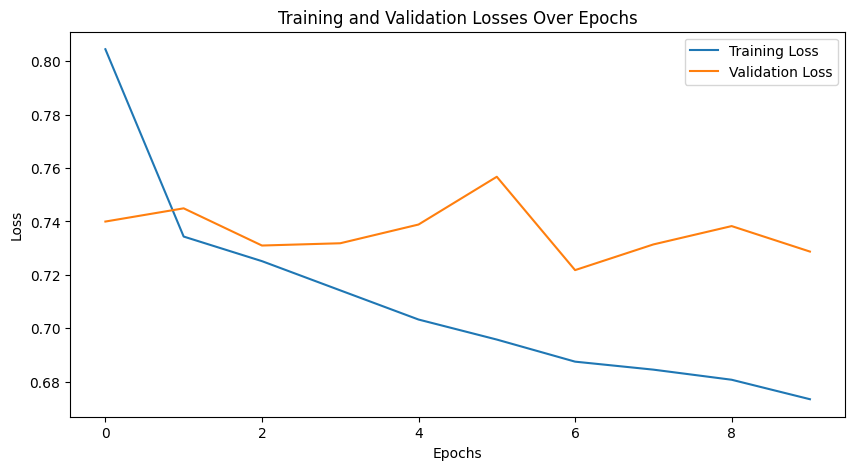

In [27]:
import matplotlib.pyplot as plt

# 1. Initialize the dataset and dataloaders
demo_dataset = BaseDataset(proc_dp="data/proc_demo/", primary_dset=["mb_na"], secondary_dset=[], 
                           ce_key="nce", inst_type=["FT"], frag_mode=["HCD"], ion_mode="P", process_spec_old=False,
                           pos_prec_type=['[M+H]+', '[M+H-H2O]+', '[M+H-2H2O]+', '[M+2H]2+', '[M+H-NH3]+', "[M+Na]+"],
                           preproc_ce="normalize", mz_max=1000., convert_ce=False, subsample_size=0, num_entries=-1,
                           spectrum_normalization="l1", res=[1,2,3,4,5,6,7], mz_bin_res=1., ints_thresh=0., transform="log10over3")

# Get dataloaders using the method provided by the BaseDataset class
run_d = {
    "val_frac": 0.1,
    "test_frac": 0.2,
    "sec_frac": 1.00,
    "split_key": "scaffold",
    "split_seed": 42,
    "batch_size": 32,
    "grad_acc_interval": 1,
    "num_workers": 0,
    "pin_memory": True,
    "device": "cuda" if th.cuda.is_available() else "cpu",
}

dl_dict, split_id_dict = demo_dataset.get_dataloaders(run_d)

train_loader = dl_dict['train']
val_loader = dl_dict['primary']['val']

# 2. Define the model, loss function, and optimizer
graphormer_config = GraphormerConfig()  # Assume this is set up properly
massformer_example = MassFormer(graphormer_config)
# Define the cosine similarity measure
cosine_similarity = th.nn.CosineSimilarity(dim=1, eps=1e-6)
def cosine_similarity_loss(output, target):
    # Cosine similarity is between -1 and 1. Higher is better. So we subtract from 1 to create a loss.
    cosine_loss =  1 - th.clamp(cosine_similarity(output, target), min=0, max=1)
    return cosine_loss.mean()

optimizer = th.optim.Adam(massformer_example.parameters(), lr=1e-4)

# If using a GPU
device = th.device("cuda" if th.cuda.is_available() else "cpu")
massformer_example.to(device)

# 3. Training and validation loop
num_epochs = 10
# Initialize lists to keep track of losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    massformer_example.train()
    total_train_loss = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        # Transfer data to GPU if needed
        batch_data = {k: v.to(device) if isinstance(v, th.Tensor) else v for k, v in batch_data.items()}
        outputs = massformer_example(batch_data)
        # Normalize labels and predictions if they are not already
        normalized_labels = F.normalize(batch_data['spec'].float(), p=2, dim=1)
        normalized_preds = F.normalize(outputs['pred'], p=2, dim=1)
        
        loss = cosine_similarity_loss(normalized_preds, normalized_labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    # Store the average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # Convert the generator object to a list
    val_loader = list(val_loader)

    # Validation
    massformer_example.eval()
    total_val_loss = 0
    with th.no_grad():
        for batch_data in val_loader:
            # Transfer data to GPU if needed
            batch_data = {k: v.to(device) if isinstance(v, th.Tensor) else v for k, v in batch_data.items()}
            outputs = massformer_example(batch_data)
            loss = cosine_similarity_loss(outputs['pred'], batch_data['spec'].float())
            total_val_loss += loss.item()

    # Store the average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss:.4f}')

# When training is done, plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Epochs')
plt.show()